# Atomic Scalability

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import argparse
from model.edieggc import EDiEGGC
from model.bgrl import BGRL
from tqdm import tqdm
import pickle

from data.data import QMugsTestDataloader, QMugsDataloader, QM9Dataloader

In [8]:
parser = argparse.ArgumentParser(description='dipole moment prediction training')
"""Experiment setting."""
parser.add_argument('--exp-name', type=str, default='qmugs_20_mmff_mu_g', help="")
parser.add_argument('--lacl', type=bool, default=True, help="True for training LACL, False for training")
parser.add_argument('--finetune', type=bool, default=False, help="")
parser.add_argument('--freeze', type=bool, default=False, help="")
parser.add_argument('--update_moving_average', type=bool, default=True, help="")
parser.add_argument('--loss', type=str, default='contrastive+prediction', help="")
parser.add_argument('--num-workers', type=int, default=6, help="")
parser.add_argument('--dataset', type=str, default='QMugs', help="data-chemical")
parser.add_argument('--set', type=str, default='src', help="'src' for source domain and 'tgt' for target domain")
parser.add_argument('--target', type=str, default='GFN2:TOTAL_FREE_ENERGY', help="homo, lumo, gap, mu, ...")
parser.add_argument('--geometry', type=str, default='MMFF', help="")
parser.add_argument('--epochs', type=int, default=300, help="")
parser.add_argument('--num-train', type=int, default=65000, help="110000/65000")
parser.add_argument('--num-valid', type=int, default=1500, help="10000/1500")
parser.add_argument('--num-test', type=int, default=1706, help="10829/1706")
parser.add_argument('--batch-size', type=int, default=32, help="")
parser.add_argument('--learning-rate', type=float, default=1e-3, help="")
parser.add_argument('--weight-decay', type=float, default=0, help="")
parser.add_argument('--max-norm', type=float, default=1000.0, help="")
parser.add_argument('--scheduler', type=str, default='plateau', help="")
parser.add_argument('--cutoff', type=float, default=4.0, help="")
parser.add_argument('--device', type=str, default='cuda:3', help="cuda device")
'''Model setting'''
parser.add_argument('--embedding-type', type=str, default='cgcnn', help="")
parser.add_argument('--alignn-layers', type=int, default=4, help="")
parser.add_argument('--gcn-layers', type=int, default=4, help="")
parser.add_argument('--atom-input-features', type=int, default=92, help="")
parser.add_argument('--edge-input-features', type=int, default=80, help="")
parser.add_argument('--triplet-input-features', type=int, default=40, help="")
parser.add_argument('--embedding-features', type=int, default=64, help="")
parser.add_argument('--hidden-features', type=int, default=256, help="")
parser.add_argument('--output-features', type=int, default=1, help="")
args = parser.parse_args([])

In [ ]:
checkpoint = 'logs/20230819_163035_qmugs_20_mmff_fe_g/qmugs_20_mmff_fe_g'
typeofs = list(range(21, 40)) + ['ex']
test_maes = []
for typeof in typeofs:
    args.typeof = typeof
    test_loader = QMugsTestDataloader(args)
    if args.lacl:
        model = BGRL(args)
        model.load_state_dict(torch.load(checkpoint))
        model.to(args.device)
        model.eval()
        # inference
        labels = []
        pred1s = []
        pred2s = []
        for g1, lg1, g2, lg2, label in tqdm(test_loader):
            g1 = g1.to(args.device)
            lg1 = lg1.to(args.device)
            g2 = g2.to(args.device)
            lg2 = lg2.to(args.device)
            label = label.to(args.device)
            with torch.no_grad():
                pred_1, pred_2, bgrl_loss, _, _, _, _ = model(g1, lg1, g2, lg2)
            labels.append(label.detach().cpu().numpy())
            pred1s.append(pred_1.detach().cpu().numpy())
            pred2s.append(pred_2.detach().cpu().numpy())
        labels = np.hstack(labels)
        pred1s = np.hstack(pred1s)
        pred2s = np.hstack(pred2s)
    else:
        # Load model
        model = EDiEGGC(args)
        model.load_state_dict(torch.load('logs/20230819_163035_qmugs_20_mmff_fe_g/qmugs_20_mmff_fe_g'))
        model.to(args.device)
        model.eval()
        # inference
        labels = []
        pred1s = []
        pred2s = []
        loss = 0.0
        for g1, lg1, g2, lg2, label in tqdm(test_loader):
            g1 = g1.to(args.device)
            lg1 = lg1.to(args.device)
            g2 = g2.to(args.device)
            lg2 = lg2.to(args.device)
            label = label.to(args.device)
            with torch.no_grad():
                pred1, _, _, _, _ = model(g1, lg1)
                pred2 , _, _, _, _ = model(g2, lg2)
            # loss += g1.batch_size * torch.nn.functional.l1_loss(pred, label).item()
            labels.append(label.detach().cpu().numpy())
            pred1s.append(pred1.detach().cpu().numpy())
            pred2s.append(pred2.detach().cpu().numpy())
        labels = np.hstack(labels)
        pred1s = np.hstack(pred1s)
        pred2s = np.hstack(pred2s)
    test_maes.append([np.mean(np.abs(labels-pred1s)), np.mean(np.abs(labels-pred2s)), np.mean(np.abs(labels-np.mean(labels))), np.mean(labels)])

In [10]:
with open('./data/QMugs/scalability_fe_alignn.pkl', 'wb') as f:
    pickle.dump(test_maes, f)

In [11]:
with open('./data/QMugs/scalability_mu.pkl', 'rb') as f:
    test_maes_mu = pickle.load(f)
with open('./data/QMugs/scalability_gap.pkl', 'rb') as f:
    test_maes_gap = pickle.load(f)
with open('./data/QMugs/scalability_fe.pkl', 'rb') as f:
    test_maes_fe = pickle.load(f)
with open('./data/QMugs/scalability_mu_alignn.pkl', 'rb') as f:
    test_maes_mu_a = pickle.load(f)
with open('./data/QMugs/scalability_gap_alignn.pkl', 'rb') as f:
    test_maes_gap_a = pickle.load(f)
with open('./data/QMugs/scalability_fe_alignn.pkl', 'rb') as f:
    test_maes_fe_a = pickle.load(f)

<class 'matplotlib.axes._subplots.AxesSubplot'>


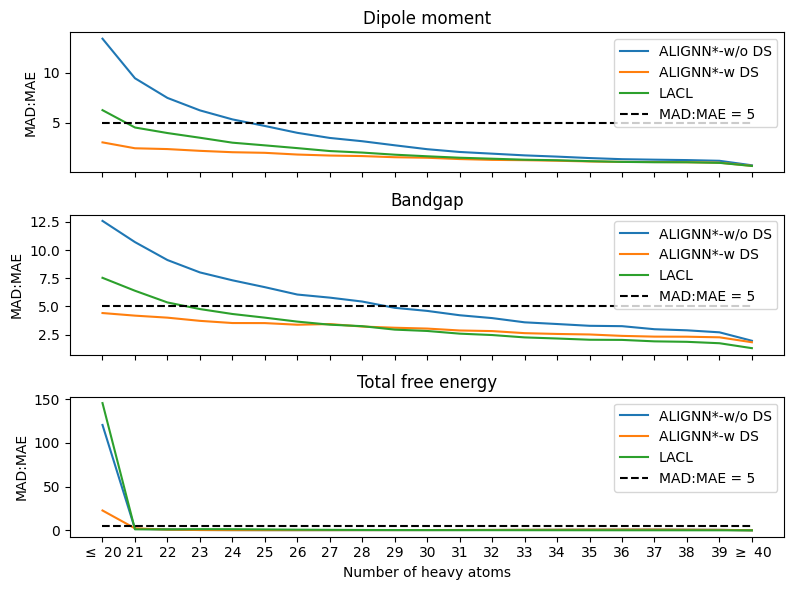

In [20]:
# 3 x 1 subplots
x_axis = [r'$\leq$ 20']+list(range(21,40))+[r'$\geq$ 40']
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
print(type(axes[0]))
# fig.suptitle('Scalability of ALIGNN', fontsize=16)
axes[0].plot(x_axis, 1.644/np.hstack([[0.12264], np.array(test_maes_mu_a)[:,0]]), label='ALIGNN*-w/o DS')
axes[0].plot(x_axis, 1.644/np.hstack([[0.54571], np.array(test_maes_mu_a)[:,1]]), label='ALIGNN*-w DS')
axes[0].plot(x_axis, 1.644/np.hstack([[0.2634], np.array(test_maes_mu)[:,1]]), label='LACL')
axes[0].plot([r'$\leq$ 20', r'$\geq$ 40'], [5,5], label='MAD:MAE = 5', c='black', linestyle='--')
axes[0].set_ylabel('MAD:MAE')
axes[0].set_title('Dipole moment')
axes[0].legend(loc='upper right')

axes[1].plot(x_axis, 23.28/np.hstack([[0.00185], np.array(test_maes_gap_a)[:,0]])/1000, label='ALIGNN*-w/o DS')#, color='orange')
axes[1].plot(x_axis, 23.28/np.hstack([[0.00528], np.array(test_maes_gap_a)[:,1]])/1000, label='ALIGNN*-w DS')#, color='orange')
axes[1].plot(x_axis, 23.28/np.hstack([[0.00309], np.array(test_maes_gap)[:,1]])/1000, label='LACL')#, color='orange')
axes[1].plot([r'$\leq$ 20', r'$\geq$ 40'], [5,5], label='MAD:MAE = 5', c='black', linestyle='--')
axes[1].set_ylabel('MAD:MAE')
axes[1].set_title('Bandgap')
axes[1].legend()

axes[2].plot(x_axis, 6028/np.hstack([[0.05007], np.array(test_maes_fe_a)[:,0]])/1000, label='ALIGNN*-w/o DS')#, color='green')
axes[2].plot(x_axis, 6028/np.hstack([[0.26481], np.array(test_maes_fe_a)[:,1]])/1000, label='ALIGNN*-w DS')#, color='green')
axes[2].plot(x_axis, 6028/np.hstack([[0.04147], np.array(test_maes_fe)[:,1]])/1000, label='LACL')#, color='green')
axes[2].plot([r'$\leq$ 20', r'$\geq$ 40'], [5,5], label='MAD:MAE = 5', c='black', linestyle='--')
axes[2].set_ylabel('MAD:MAE')
axes[2].set_title('Total free energy')
axes[2].legend()
plt.xlabel('Number of heavy atoms')
plt.tight_layout()